In [39]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import re
import nltk.data
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
data = pd.read_csv("data/twitter-suicidal_data.csv")
data.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/renatopc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
data['intention'].value_counts()

intention
0    5121
1    3998
Name: count, dtype: int64

In [5]:
data.isna().sum()

tweet        0
intention    0
dtype: int64

In [6]:
data['tweet'] = data['tweet'].astype(str)

In [7]:
stemmer = PorterStemmer()

In [8]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    text = text.lower().split()

    text = [stemmer.stem(word) for word in text if word not in stopwords.words('english')]

    return ' '.join(text)

In [9]:
data['Cleaned_Tweet'] = data['tweet'].apply(clean_text)

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(data['Cleaned_Tweet']).toarray()
y = data['intention']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
clf = RandomForestClassifier(random_state=42, n_estimators=366, min_samples_split=5,
                             min_samples_leaf=2, max_features='sqrt', 
                             class_weight='balanced', max_depth=55, 
                             criterion='entropy', bootstrap=False)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=55, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=366, random_state=42)

In [46]:
clf_svc = SVC(kernel='poly', gamma='scale', degree=3, coef0=0.4, C=10)
clf_svc.fit(X_train, y_train)

SVC(C=10, coef0=0.4, kernel='poly')

In [47]:
y_pred_svc = clf_svc.predict(X_test)

In [48]:
class_rep = classification_report(y_test, y_pred_svc)
print("Classification Report:\n", class_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      1506
           1       0.95      0.87      0.91      1230

    accuracy                           0.92      2736
   macro avg       0.92      0.92      0.92      2736
weighted avg       0.92      0.92      0.92      2736



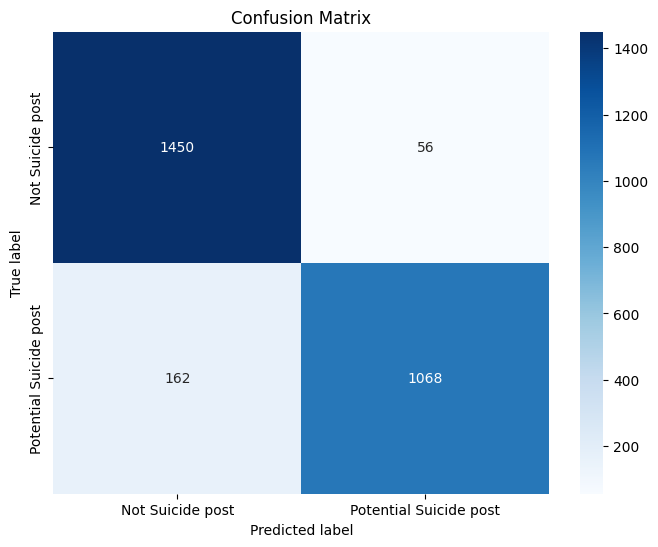

In [49]:
confusion_mat = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Not Suicide post', 'Potential Suicide post'],
            yticklabels=['Not Suicide post', 'Potential Suicide post'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [35]:
y_pred_rfc = clf.predict(X_test)

In [36]:
class_rep = classification_report(y_test, y_pred_rfc)
print("Classification Report:\n", class_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92      1506
           1       0.94      0.85      0.89      1230

    accuracy                           0.91      2736
   macro avg       0.91      0.90      0.91      2736
weighted avg       0.91      0.91      0.91      2736



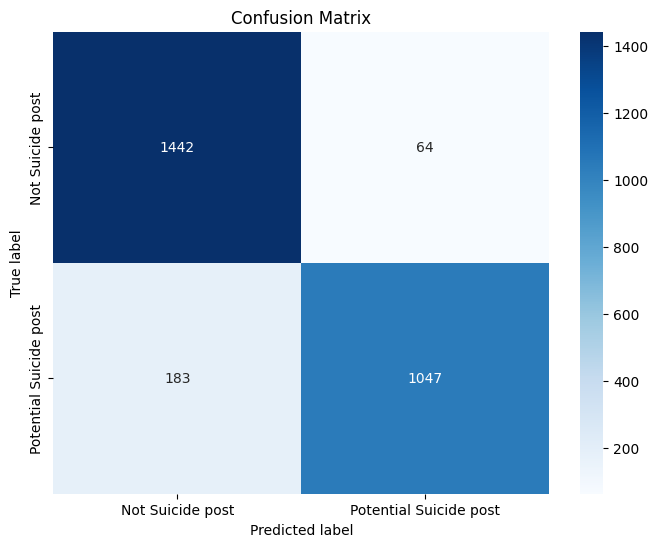

In [37]:
confusion_mat = confusion_matrix(y_test, y_pred_rfc)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Not Suicide post', 'Potential Suicide post'],
            yticklabels=['Not Suicide post', 'Potential Suicide post'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [38]:
from sklearn.model_selection import RandomizedSearchCV


criterion = ['gini', 'entropy', 'log_loss']
class_weight_rs = ['balanced', 'balanced_subsample']
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 55, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'criterion': criterion,
               'class_weight': class_weight_rs,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_cv_rf = RandomizedSearchCV(
    clf,
    random_grid,
    n_iter=3,
    scoring='recall',
    n_jobs=-1,
    random_state=42
)

randomcv_rf = random_cv_rf.fit(X_train, y_train)

print(randomcv_rf.best_params_)
print(randomcv_rf.best_score_)

{'n_estimators': 366, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 55, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': False}
0.8374361049999672


In [45]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'degree': [2, 3, 4, 5],
    'gamma': ['auto', 'scale', '1e-2', '1e-3', '1e-4'],
    'coef0': [0.0, 0.1, 0.2, 0.3, 0.4],
}

random_cv_svc = RandomizedSearchCV(
    clf_svc,
    param_grid,
    n_iter=3,
    scoring='recall',
    n_jobs=-1,
    random_state=42
)

randomcv_svc = random_cv_svc.fit(X_train, y_train)

print(randomcv_svc.best_params_)
print(randomcv_svc.best_score_)

{'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'coef0': 0.4, 'C': 10}
0.8493559906254692


In [57]:
def classify_msg(msg):
    cleaned_msg = clean_text(msg)
    transformed_msg = tfidf_vectorizer.transform([cleaned_msg]).toarray()

    prediction = clf_svc.predict(transformed_msg)

    if prediction[0] == 0:
        return "Não é uma mensagem com tendencias suicidas"
    else:
        return "Esté é uma mensagem com tendencias suicidas"

In [68]:
msg_test = ["I am feeling so happy today!",
    "Life is so difficult, I can't take it anymore.",
    "Everything is going great!",
    "I don't know how much longer I can go on like this",
    "I wish I didn't need to breathe anymore",
    "Today I'm going to travel again!"]

classified_results = {msg: classify_msg(msg) for msg in msg_test}
print("Classification Results:", classified_results)

Classification Results: {'I am feeling so happy today!': 'Não é uma mensagem com tendencias suicidas', "Life is so difficult, I can't take it anymore.": 'Esté é uma mensagem com tendencias suicidas', 'Everything is going great!': 'Não é uma mensagem com tendencias suicidas', "I don't know how much longer I can go on like this": 'Esté é uma mensagem com tendencias suicidas', "I wish I didn't need to breathe anymore": 'Esté é uma mensagem com tendencias suicidas', "Today I'm going to travel again!": 'Não é uma mensagem com tendencias suicidas'}


In [72]:
import pickle

with open("model/modelo_salvo", 'wb') as file:
    pickle.dump({
        'model': clf_svc,
        'tfidf_vectorizer': tfidf_vectorizer,
    }, file)